In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import sys
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
###Helper Functions
def single_feature_plot(reshaped_features, y):
    X = reshaped_features
    plt.scatter(list(range(0, 19)), X[list(range(0, 19))])
    plt.scatter(list(range(19, 38)), X[list(range(19, 38))])
    plt.ylabel("feature")
    plt.xlabel("Measure")
    plt.title("Training Set (First LED)")
    plt.show()
    plt.scatter(list(range(0, 19)), y[list(range(0, 19))])
    plt.scatter(list(range(19, 38)), y[list(range(19, 38))])
    plt.title("Label Set")
    plt.ylabel("Label value")
    plt.xlabel("Measure")
    plt.show()
    
def features_plot(features):
    xx = features
    fbx_values = np.zeros([int((xx.shape[0])/2), xx.shape[1]])
    fby_values = np.zeros([int((xx.shape[0])/2), xx.shape[1]])
    j = 0; k = 0
    for i in range(xx.shape[0]):
        if i % 2 == 0:
            fbx_values[j, :] = xx[i, :]
            j += 1
        if i % 2 != 0:
            fby_values[k, :] = xx[i, :]
            k += 1
    fbx_values.reshape(-1, 1)
    fby_values.reshape(-1, 1)
    plt.scatter(list(range(fbx_values.reshape(-1, 1).shape[0])), fbx_values)
    plt.scatter(list(range(fby_values.reshape(-1, 1).shape[0])), fby_values)
    plt.ylabel("feature")
    plt.xlabel("Measure")
    plt.title("Training Set (Full set)")
    plt.show() 

Data Handling

In [68]:
###Features
data = pd.read_excel('./2_Results/Target.xlsx', header=None).iloc[3:, 1:20]
data = data.reset_index(drop=True) #Resets the rows index to start in zero again
data.columns = range(data.shape[1]) #Resets the columns index to start in zero again
data = data.values #Extract the values as a ndarray
print(data.shape)
###Labels
ones = np.ones(data.shape[1])
ones = np.expand_dims(ones, axis=0)
labels = np.zeros([data.shape[0], data.shape[1]])
for i in range(labels.shape[0]):
    if i % 2 != 0:
        labels[i, :] = ones
###Save data
features_path = './3_Extra/training_data/Classification_for_fibers.npy'
labes_path = './3_Extra/training_data/fibers_labels.npy'
np.save(features_path, data)
np.save(labes_path, labels)

(24, 19)


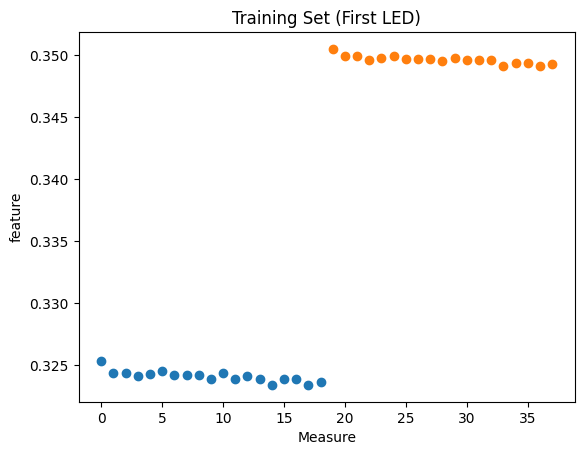

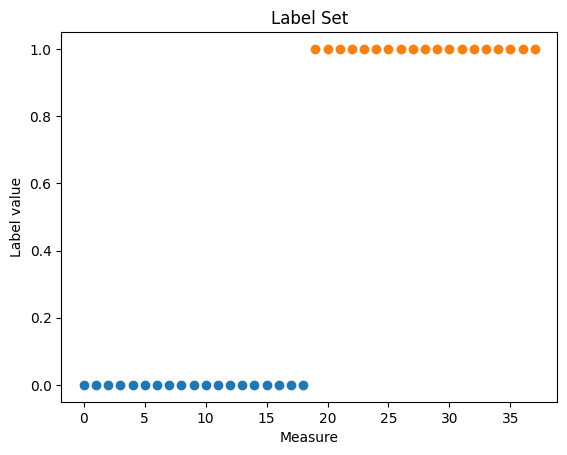

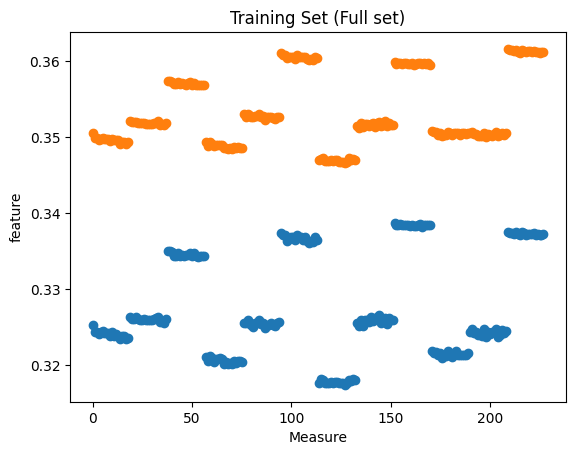

In [69]:
###Data loading and reshaping
X = np.load(features_path).reshape(-1, 1)
y = np.load(labes_path).reshape(-1, 1)
y = y.ravel()
###Data plotting
#Single pair of fbx, fby features and labels
single_feature_plot(X, y)
#Full dataset plotting
xx = np.load(features_path)
features_plot(xx)

Logistic Regression with one feature

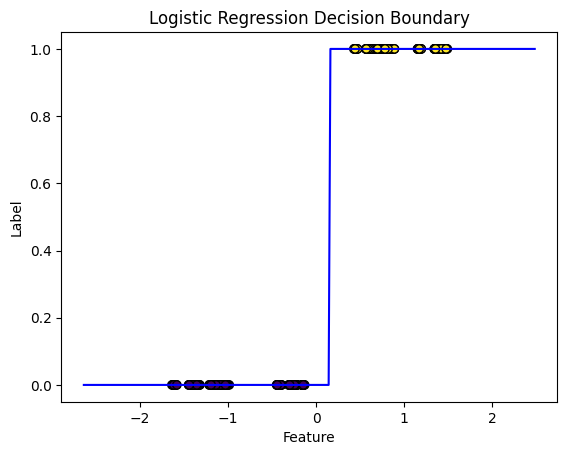

In [70]:
###Training
#Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)
#Create and train the model
classifier = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
classifier.fit(X_train, y_train)
x_min, x_max = X.min() - 1, X.max() + 1 #Boundaries to fit all training values
xx = np.arange(x_min, x_max, 0.02).reshape(-1, 1) #Independent variable array that covers all values to be predicted 
Z = classifier.predict(xx) #Generates a prediction for the array
#Plot the results
plt.plot(xx, Z, color='blue')
plt.scatter(X_train, y_train, c=y_train, edgecolors='k')
plt.xlabel('Feature')
plt.ylabel('Label')
plt.title('Logistic Regression Decision Boundary')
plt.show()

In [71]:
###Testing
#Predict and compare values of the test set
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 1.0


In [72]:
#Get the parameters of the model
weights = classifier.coef_
bias = classifier.intercept_
print("Weights:", weights[0][0])
print("Bias:", bias[0])

Weights: 5.549313041182366
Bias: -0.8416343324641112


Crossvalidation evaluation

In [73]:
classifier2 = LogisticRegression()
cv_scores = cross_val_score(classifier2, X, y, cv=5)  # 5-fold cross-validation
classifier2.fit(X, y)
print("Accuracy scores for each fold:", cv_scores)
print("Mean accuracy:", np.mean(cv_scores))
print("Standard deviation:", np.std(cv_scores))
classifier_score = classifier2.score(X, y)

Accuracy scores for each fold: [1. 1. 1. 1. 1.]
Mean accuracy: 1.0
Standard deviation: 0.0


K-means two features (Measure and measure number)

In [74]:
###Data preparation
X_train = data.reshape(-1, 1)
measure = np.arange(X_train.shape[0]).reshape(-1, 1)
X_train = np.concatenate((measure, X_train), axis=1)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

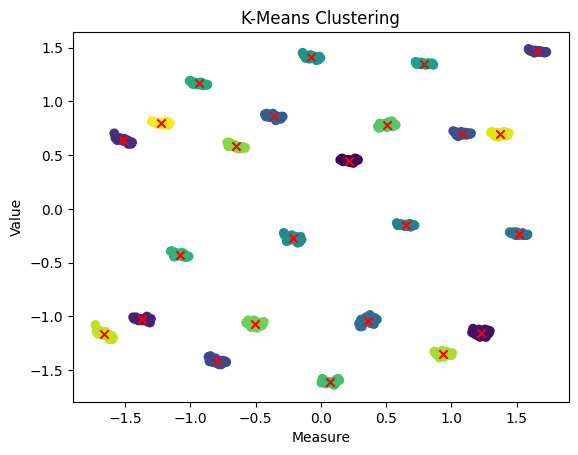

In [75]:
###Clustering
#Choose the number of clusters
k = 24
#Create KMeans instance and fit the data
kmeans = KMeans(n_clusters=k, n_init=100)
kmeans.fit(X_train)
#Get cluster centers and labels
cluster_centers = kmeans.cluster_centers_
labels = kmeans.labels_
#Plot the data and cluster centers
plt.scatter(X_train[:, 0], X_train[:, 1], c=labels, cmap='viridis')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x')
plt.title("K-Means Clustering")
plt.xlabel("Measure")
plt.ylabel("Value")
plt.show()

Optimal WCSS: 82.2620789025682, Centroids: 8


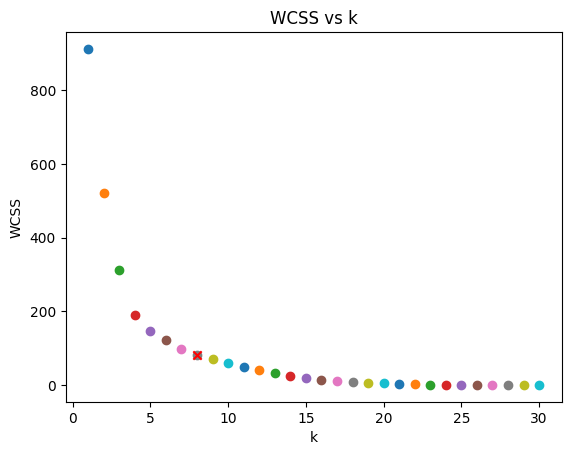

In [76]:
k_var = 30

def centroid_optimizer(max_centroids = 30, training_set = 0, quality = 0):
    '''Determines an optimal number of centroids for a given dataset using the elbow method
    quality: Determines the precision of the search. Higher qualities can output no valid k'''
    if not isinstance(training_set, np.ndarray):
        raise ValueError("Invalid dataset format")
    match quality:
        case quality if quality == 1:
            fork = (10, 50)
        case quality if quality == 2:
            fork = (20, 100)
        case quality if quality == 3:
            fork = (50, 300)
        case quality: 
            fork = (200, 500)
    WCSS_array = np.zeros(len(range(1, k_var+1)))
    optimal_array = []
    for k in (range(1, max_centroids+1)):
        kmeans = KMeans(n_clusters=k, n_init=25)
        kmeans.fit(training_set)
        WCSS_array[k-1] = kmeans.inertia_
        plt.scatter(k, WCSS_array[k-1])
        if k != 1:
            derivative = -(WCSS_array[k-1]-WCSS_array[k-2])/(k-(k-1)) #Calculates the derivative
            if derivative < fork[1] and derivative > fork[0]:
                optimal_array.append(k)
        else:
            pass
    try:
        optimal_k = round(np.mean(optimal_array)) #Calculates the mean of the selected k values and approximates it to the best possible.
    except ValueError:
        print("Quality value too high. Try a lower quality.")
        sys.exit(1)
    plt.scatter(optimal_k, WCSS_array[optimal_k-1], marker='x', c='red')
    print(f"Optimal WCSS: {WCSS_array[optimal_k-1]}, Centroids: {optimal_k}")
    plt.title("WCSS vs k")
    plt.xlabel("k")
    plt.ylabel("WCSS")
    plt.show()

centroid_optimizer(max_centroids = k_var, training_set = X_train, quality = 1)